In [2]:
from torch import nn
import torch
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from torchvision import datasets, transforms, utils
from src.utility import convert_image_np
import tqdm
from collections import defaultdict
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import gridspec
from lib.data import Mimic2
from lib.utility import show_tensor_image, show_acc, to_var
from lib.model import MLP
from lib.openbox import open_box, count_config, find_x

In [3]:
def train(net, trainloader, criterion, optimizer, print_every=None, epochs=1000, max_time=10):
    net.train()
    start = time.time()
    
    # max_time given in seconds
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, (x, y) in enumerate(trainloader):
            
            end = time.time()
            if end - start >= max_time:
                print('Finished Training in %ds' % (end-start))                
                return
            
            # get the inputs
            x, y = to_var(x), to_var(y)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.data.item()
            if print_every is not None and i % print_every == (print_every-1): 
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / print_every))
                running_loss = 0.0

    print('Finished Training in %ds' % (end-start))

# OpenboxCNN

In [ ]:
class CNN(nn.Module):

    def __init__(self, neuron_sizes): # using relu activation
        super(MLP, self).__init__()
        self.neuron_sizes = neuron_sizes
        
        layers = []
        for s0, s1 in zip(neuron_sizes[:-1], neuron_sizes[1:]):
            layers.extend([
                nn.Linear(s0, s1),
                nn.LeakyReLU(inplace=True)
            ])
        
        self.classifier = nn.Sequential(*layers[:-1])
        
    def forward(self, x):
        x = x.view(-1, self.neuron_sizes[0])
        return self.classifier(x)


checking if it is exact
min: 0.000000, mean: 0.000000, max: 0.000000


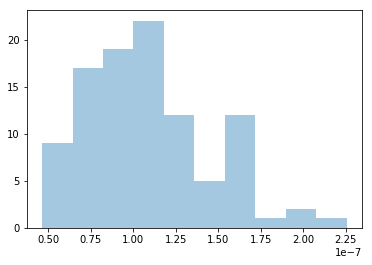

In [5]:
def abs_diff(a, b):
    return torch.abs(a - b).sum().data.numpy()

def diff_check(net, num_runs=100):
    diff = []
    d = net.classifier[0].in_features
    for i in range(num_runs):
        x = to_var(torch.randn(d))
        W, b, C = open_box(net, x)
        diff.append(abs_diff(torch.mv(W, x) + b, net(x)))
    return diff

diff = diff_check(MLP([100,50,30,20,10]))
sns.distplot(diff, kde=False)
print('checking if it is exact')
print('min: %f, mean: %f, max: %f' % (np.min(diff), np.mean(diff), np.max(diff)))